In [1]:
## Imports
import os
import sys
import random
from tqdm import tqdm 
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

## Data Generator

In [40]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
#         image_path = os.path.join(self.path, id_name, "images", id_name) + ".JPG"
        image_path = os.path.join(self.path, id_name, "images", id_name[id_name.find("(")+1:id_name.find(")")]) + ".jpg"
#         print(image_path)
        mask_path = os.path.join(self.path, id_name, "MaskFull\\")
#         print(mask_path)
        all_masks = os.listdir(mask_path)
#         print(all_masks)
        ## Reading Image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
#         print(image)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = np.zeros((self.image_size, self.image_size, 1))
        
        ## Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, cv2.IMREAD_GRAYSCALE)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)
            
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

## Hyperparameters

In [41]:
image_size = 256
# train_path = "C:/Users/BS579/Desktop/UNet-TF/new Aedes Unet Dataset - Copy"
# train_path = "C:/Users/BS579/Desktop/UNet-TF/data set/data set - Copy"
train_path = "C:/Users/BS579/Desktop/UNet-TF/new Aedes Unet Dataset - 2022"
epochs = 100
batch_size = 8

## Training Ids
train_ids = next(os.walk(train_path))[1]

# print(train_ids)
random.shuffle(train_ids)
# print(train_ids)
## Validation Data Size
val_data_size = 3
valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]
print(valid_ids)

['2 - Copy (80)', '2 - Copy (56)', '2 - Copy (61)']


In [42]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(8, 256, 256, 3) (8, 256, 256, 1)


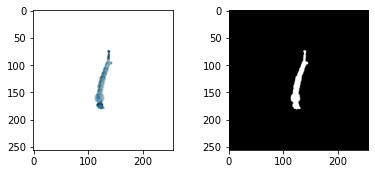

In [43]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

## Different Convolutional Blocks

In [44]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

## UNet Model

In [45]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [46]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 128, 128, 16) 0           conv2d_20[0][0]                  
____________________________________________________________________________________________

## Training the model

In [47]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

Epoch 1/100
6/6 [==============================] - 9s 1s/step - loss: 0.6755 - acc: 0.4786
Epoch 2/100
6/6 [==============================] - 5s 806ms/step - loss: 0.3829 - acc: 0.9093
Epoch 3/100
6/6 [==============================] - 5s 778ms/step - loss: 0.3096 - acc: 0.9017
Epoch 4/100
6/6 [==============================] - 4s 742ms/step - loss: 0.2842 - acc: 0.8949
Epoch 5/100
6/6 [==============================] - 5s 754ms/step - loss: 0.2283 - acc: 0.9179
Epoch 6/100
6/6 [==============================] - 4s 730ms/step - loss: 0.2589 - acc: 0.8762
Epoch 7/100
6/6 [==============================] - 4s 729ms/step - loss: 0.2469 - acc: 0.8927
Epoch 8/100
6/6 [==============================] - 5s 756ms/step - loss: 0.1959 - acc: 0.8937
Epoch 9/100
6/6 [==============================] - 5s 786ms/step - loss: 0.1902 - acc: 0.9074
Epoch 10/100
6/6 [==============================] - 5s 804ms/step - loss: 0.1689 - acc: 0.9252
Epoch 11/100
6/6 [==============================] - 5s 864ms/s

## Testing the model

In [48]:
## Save the Weights
model.save_weights("UNetMos.h5")
# print(valid_ids)
## Dataset for prediction
x, y = valid_gen.__getitem__(0)
# print(x)
result = model.predict(x)
print(result.shape)
result = result > 0.5

(3, 256, 256, 1)


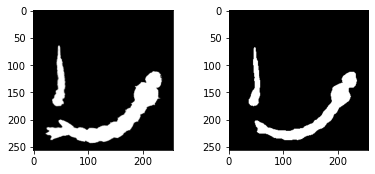

In [49]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

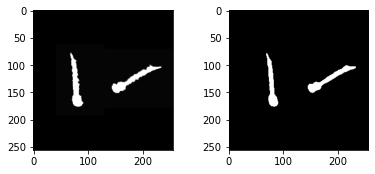

In [50]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")

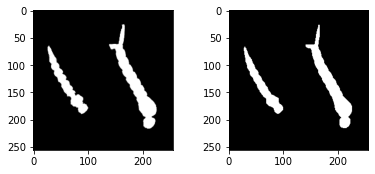

In [51]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[2]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[2]*255, (image_size, image_size)), cmap="gray")

In [52]:
from keras.metrics import MeanIoU

m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state(y[0], result[0])
print(m.result().numpy()*100)
m.reset_state()
m.update_state(y[1], result[1])
print(m.result().numpy()*100)
m.reset_state()


85.43018698692322
82.68152475357056


In [53]:
# Intersection-Over-Union (IoU, Jaccard Index)
from keras import backend as K
def iou_coef(target, prediction):
  intersection = np.logical_and(target, prediction)
  union = np.logical_or(target, prediction)
  iou_score = np.sum(intersection) / np.sum(union)
  return iou_score

In [54]:
# Dice Coefficient (F1 Score)
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    return 2. * intersection / union

In [55]:
print(dice_coef(y[1], result[1]))

0.8238527023207386


In [58]:
# from sklearn.metrics import jaccard_score
# # m = sklearn.metrics.jaccard_score(num_classes=2)
# jaccard_score(y[1][0], result[1][0],zero_division=0.0)

In [59]:
# from sklearn.metrics import f1_score
# f1_score(y[1][1:255], result[1][1:255],zero_division=1.0)